# IDVE Assignment 1

## Group Members:
- Blessing Kodze - 2560370
- Phemelo Masilo -
- Sean Mahlanza - 2438634
- Gael Joao - 2494554

## Imports

In [149]:
# Core data handling
import pandas as pd
import numpy as np
from pathlib import Path

import re
from datetime import datetime
import dateutil.parser

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import math

import warnings
warnings.filterwarnings("ignore")

In [150]:
csv_path = Path("logbook_assignment1.csv")
if csv_path is None:
    raise FileNotFoundError("Could not find 'logbook_assignment1.csv' in the working directory")

In [151]:
df = pd.read_csv(csv_path, dtype=str)  # read everything as string first (dataset is messy)
print(f"Loaded {len(df):,} rows from: {csv_path}")

Loaded 1,174,870 rows from: logbook_assignment1.csv


In [152]:
# Peek at the columns we care about (ensure expected names exist)
expected_cols = ['date_fueled', 'date_captured', 'odometer', 'gallons', 'cost_per_gallon', 'total_spent', 'mpg', 'miles', 'user_url']
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    print("Warning: Missing expected columns:", missing)
else:
    print("All expected columns present.")

All expected columns present.


## 1.1 Date Fields
### 1. Percentage of date fueled entries that are not proper dates.


In [153]:
def clean_date_str(s: pd.Series) -> pd.Series:
    """
    Light string cleanup:
    - Ensure string type
    - Strip whitespace
    - Remove stray single/double quotes
    - Collapse multiple internal spaces to a single space
    """
    s = s.astype("string")
    s = s.str.strip()
    s = s.str.replace('"', '', regex=False).str.replace("'", "", regex=False)
    s = s.str.replace(r"\s+", " ", regex=True)  # compress whitespace
    return s

def parse_mmmdyyyy(series: pd.Series) -> pd.Series:
    """
    Parse dates strictly in format '%b %d %Y' e.g., 'Jan 9 2014'.
    Returns datetime64[ns] with NaT for invalids.
    """
    cleaned = clean_date_str(series)
    parsed = pd.to_datetime(cleaned, format="%b %d %Y", errors="coerce")
    return parsed

# Create parsed columns (do not mutate originals)
parsed_date_fueled = parse_mmmdyyyy(df['date_fueled'])
parsed_date_captured = parse_mmmdyyyy(df['date_captured'])

valid_fueled_mask = parsed_date_fueled.notna()
valid_captured_mask = parsed_date_captured.notna()

percent_not_proper_date = (1.0 - valid_fueled_mask.mean()) * 100.0
print(f"Q1.1(1) — Percentage of 'date_fueled' entries that are NOT proper dates: {percent_not_proper_date:.2f}%")
print(f"Valid 'date_fueled': {valid_fueled_mask.sum():,} / {len(df):,}")
print(f"Invalid 'date_fueled': {(~valid_fueled_mask).sum():,} / {len(df):,}")

Q1.1(1) — Percentage of 'date_fueled' entries that are NOT proper dates: 11.68%
Valid 'date_fueled': 1,037,660 / 1,174,870
Invalid 'date_fueled': 137,210 / 1,174,870


### Q1.1(2) Replace NAT with values from the date captured column

In [154]:
# If 'date_fueled' is invalid and 'date_captured' is valid, use 'date_captured' as a proxy.
# We'll create a clean datetime column 'date_fueled_clean' for analysis.

df['date_fueled_clean'] = parsed_date_fueled  # start with parsed 'date_fueled'
to_fill_mask = (~valid_fueled_mask) & (valid_captured_mask)

filled_count = to_fill_mask.sum()
df.loc[to_fill_mask, 'date_fueled_clean'] = parsed_date_captured.loc[to_fill_mask]

# Report post-fill validity
post_valid_mask = df['date_fueled_clean'].notna()
post_invalid_count = (~post_valid_mask).sum()
post_invalid_pct = (post_invalid_count / len(df)) * 100.0

print(f"Q1.1(2) — Filled proxy dates from 'date_captured' for {filled_count:,} rows.")
print(f"After filling, remaining invalid 'date_fueled_clean': {post_invalid_count:,} rows ({post_invalid_pct:.2f}%).")

Q1.1(2) — Filled proxy dates from 'date_captured' for 137,210 rows.
After filling, remaining invalid 'date_fueled_clean': 0 rows (0.00%).


### Q1.1(3) Convert the 'date_fueled' column to proper datetime, invalids as NaT

- date_fueled_dt has the original dates formatted
- date_fueled_clean had the dates with the proxys formatted

In [155]:

df['date_fueled_dt'] = pd.to_datetime(df['date_fueled'], format="%b %d %Y", errors="coerce")

# Check how many are NaT
invalid_count = df['date_fueled_dt'].isna().sum()
invalid_pct = (invalid_count / len(df)) * 100

print(f"Q1.1(3) — Converted 'date_fueled' to datetime. Invalid entries set to NaT: {invalid_count:,} ({invalid_pct:.2f}%)")

# Update 'date_fueled_clean' to ensure it is in datetime format with NaT for invalids.
# This column had proxies filled from 'date_captured' earlier.

df['date_fueled_clean'] = pd.to_datetime(df['date_fueled_clean'], errors="coerce")

# Recheck invalids
invalid_count_clean = df['date_fueled_clean'].isna().sum()
invalid_pct_clean = (invalid_count_clean / len(df)) * 100

print(f"'date_fueled_clean' updated to datetime. Remaining invalid entries (NaT): {invalid_count_clean:,} ({invalid_pct_clean:.4f}%).")

Q1.1(3) — Converted 'date_fueled' to datetime. Invalid entries set to NaT: 137,210 (11.68%)
'date_fueled_clean' updated to datetime. Remaining invalid entries (NaT): 0 (0.0000%).


### Q1.1(4) Remove dates in the future or earlier than 2005 from 'date_fueled_clean'

In [156]:

# Define valid date range: 2005-01-01 <= date <= today
min_date = pd.Timestamp("2005-01-01")
max_date = pd.Timestamp.today().normalize()

initial_count = len(df)
valid_mask = (df['date_fueled_clean'] >= min_date) & (df['date_fueled_clean'] <= max_date)

removed_count = (~valid_mask).sum()
df = df.loc[valid_mask].copy()
final_count = len(df)

print(f"Q1.1(4) — Removed {removed_count:,} rows with dates outside [2005, today].")
print(f"Remaining rows: {final_count:,} (from {initial_count:,}).")

Q1.1(4) — Removed 570 rows with dates outside [2005, today].
Remaining rows: 1,174,300 (from 1,174,870).


In [157]:
df = df.reset_index(drop=True) #reset indices after deletion
df

,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,date_fueled_clean,date_fueled_dt
0,"Cooling System, Heating System, Lights, Spark ...",Apr 7 2022,"73,370",NaN,NaN,NaN,NaN,NaN,https://www.somewebsite.com/suzuki/swift/2015/...,2022-04-07,NaT
1,Nov 7 2012,Aug 30 2016,"11,983",12.120,$5.599,$67.86,31.6,NaN,https://www.somewebsite.com/bmw/x3/2009/461150,2012-11-07,2012-11-07
2,Sep 22 2012,Sep 28 2012,"98,233",7.991,£5.45,£43.53,28.5,NaN,https://www.somewebsite.com/mercedes-benz/e300...,2012-09-22,2012-09-22
3,May 4 2019,May 4 2019,"163,802",10.575,£5.11,£54.00,46.8,NaN,https://www.somewebsite.com/bmw/320d/2010/247233,2019-05-04,2019-05-04
4,Feb 15 2022,Feb 15 2022,NaN,11.651,$3.029,$35.29,21.0,244.4,https://www.somewebsite.com/honda/passport/201...,2022-02-15,2022-02-15
...,...,...,...,...,...,...,...,...,...,...,...
1174295,Feb 19 2020,Feb 19 2020,"118,237",13.046,$1.999,$26.08,25.7,NaN,https://www.somewebsite.com/volkswagen/beetle/...,2020-02-19,2020-02-19
1174296,Dec 6 2019,Dec 6 2019,"141,761",12.637,$2.449,$30.95,20.0,NaN,https://www.somewebsite.com/toyota/avalon/2000...,2019-12-06,2019-12-06
1174297,Oct 4 2021,Oct 4 2021,"65,029",10.002,$3.449,$34.50,28.5,NaN,https://www.somewebsite.com/fiat/500/2013/909694,2021-10-04,2021-10-04
1174298,Jul 26 2021,Jul 26 2021,"15,255",10.493,$3.539,$37.13,36.5,NaN,https://www.somewebsite.com/mini/cooper/2019/9...,2021-07-26,2021-07-26


### Q1.1(5) Plot the distribution of fueling dates

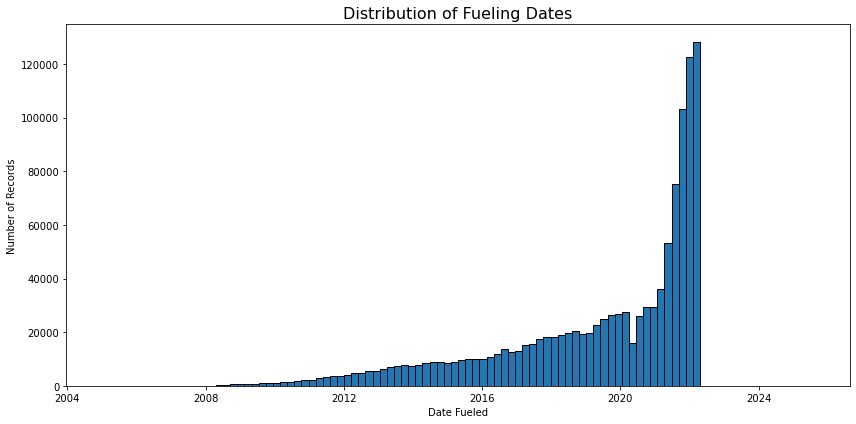

In [158]:
plt.figure(figsize=(12,6))
df['date_fueled_clean'].hist(bins=100, edgecolor='black')
plt.title("Distribution of Fueling Dates", fontsize=16)
plt.xlabel("Date Fueled")
plt.ylabel("Number of Records")
plt.grid(False)
plt.tight_layout()
plt.show()

## 1.2. Numeric Fields

(1) percentage of gallons, miles, and odometer entries are
missing.

In [159]:
numeric_cols = ['gallons', 'miles', 'odometer']

missing_stats = {}
for col in numeric_cols:
    missing_count = df[col].isna().sum() + (df[col] == "").sum()
    missing_pct = (missing_count / len(df)) * 100
    missing_stats[col] = (missing_count, missing_pct)

missing_stats_df = pd.DataFrame(missing_stats, index=["Missing Count", "Missing %"]).T
missing_stats_df

,Missing Count,Missing %
gallons,74171.0,6.316188
miles,1028143.0,87.553692
odometer,149037.0,12.691561


### Q1.2(2) Use interdependence between miles, gallons, and mpg to fill missing values.
Formula: mpg = miles / gallons

In [160]:
#convert columns to numeric (handling commas, etc. will be part of step 1.2(3))
def to_numeric(series):
    return pd.to_numeric(series.str.replace(",", "", regex=False), errors="coerce")

df['gallons_num'] = to_numeric(df['gallons'])
df['miles_num'] = to_numeric(df['miles'])
df['mpg_num'] = to_numeric(df['mpg'])

# Count missing before filling
missing_before = {
    'gallons': df['gallons_num'].isna().sum(),
    'miles': df['miles_num'].isna().sum(),
    'mpg': df['mpg_num'].isna().sum(),
}

# Fill missing mpg when miles and gallons are available
mask = df['mpg_num'].isna() & df['miles_num'].notna() & df['gallons_num'].notna() & (df['gallons_num'] != 0)
df.loc[mask, 'mpg_num'] = df.loc[mask, 'miles_num'] / df.loc[mask, 'gallons_num']

# Fill missing miles when mpg and gallons are available
mask = df['miles_num'].isna() & df['mpg_num'].notna() & df['gallons_num'].notna()
df.loc[mask, 'miles_num'] = df.loc[mask, 'mpg_num'] * df.loc[mask, 'gallons_num']

# Fill missing gallons when mpg and miles are available
mask = df['gallons_num'].isna() & df['mpg_num'].notna() & df['miles_num'].notna() & (df['mpg_num'] != 0)
df.loc[mask, 'gallons_num'] = df.loc[mask, 'miles_num'] / df.loc[mask, 'mpg_num']

# Count missing after filling
missing_after = {
    'gallons': df['gallons_num'].isna().sum(),
    'miles': df['miles_num'].isna().sum(),
    'mpg': df['mpg_num'].isna().sum(),
}

missing_before, missing_after

({'gallons': 74171, 'miles': 1028143, 'mpg': 74171},
 {'gallons': 74171, 'miles': 74171, 'mpg': 74171})

### Q1.2(3) Convert gallons, miles, and odometer to floats

In [161]:

def clean_to_float(series):
    """
    Convert string series with commas as thousand separators into floats.
    Invalid parsing results in NaN.
    """
    if series.dtype == object or pd.api.types.is_string_dtype(series):
        return pd.to_numeric(series.str.replace(",", "", regex=False), errors="coerce")
    else:
        return pd.to_numeric(series, errors="coerce")

df['gallons_clean'] = clean_to_float(df['gallons_num'])
df['miles_clean'] = clean_to_float(df['miles_num'])
df['odometer_clean'] = clean_to_float(df['odometer'])
df['mpg_clean'] = clean_to_float(df['mpg_num'])

# Check some summary statistics to confirm successful conversion
df[['gallons_clean', 'miles_clean', 'odometer_clean']].describe().T

,count,mean,std,min,25%,50%,75%,max
gallons_clean,1100129.0,12.797430,74.482791,0.0,8.99,11.9540,14.9390,28380.0
miles_clean,1100129.0,269.453801,725.763437,0.0,181.40,267.0486,342.7641,195321.2
odometer_clean,1025263.0,104001.086158,340597.635009,0.0,45924.00,91888.0000,146925.5000,254362100.0


In [162]:
df

,date_fueled,date_captured,odometer,gallons,cost_per_gallon,total_spent,mpg,miles,user_url,date_fueled_clean,date_fueled_dt,gallons_num,miles_num,mpg_num,gallons_clean,miles_clean,odometer_clean,mpg_clean
0,"Cooling System, Heating System, Lights, Spark ...",Apr 7 2022,"73,370",NaN,NaN,NaN,NaN,NaN,https://www.somewebsite.com/suzuki/swift/2015/...,2022-04-07,NaT,NaN,NaN,NaN,NaN,NaN,73370.0,NaN
1,Nov 7 2012,Aug 30 2016,"11,983",12.120,$5.599,$67.86,31.6,NaN,https://www.somewebsite.com/bmw/x3/2009/461150,2012-11-07,2012-11-07,12.120,382.9920,31.6,12.120,382.9920,11983.0,31.6
2,Sep 22 2012,Sep 28 2012,"98,233",7.991,£5.45,£43.53,28.5,NaN,https://www.somewebsite.com/mercedes-benz/e300...,2012-09-22,2012-09-22,7.991,227.7435,28.5,7.991,227.7435,98233.0,28.5
3,May 4 2019,May 4 2019,"163,802",10.575,£5.11,£54.00,46.8,NaN,https://www.somewebsite.com/bmw/320d/2010/247233,2019-05-04,2019-05-04,10.575,494.9100,46.8,10.575,494.9100,163802.0,46.8
4,Feb 15 2022,Feb 15 2022,NaN,11.651,$3.029,$35.29,21.0,244.4,https://www.somewebsite.com/honda/passport/201...,2022-02-15,2022-02-15,11.651,244.4000,21.0,11.651,244.4000,NaN,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174295,Feb 19 2020,Feb 19 2020,"118,237",13.046,$1.999,$26.08,25.7,NaN,https://www.somewebsite.com/volkswagen/beetle/...,2020-02-19,2020-02-19,13.046,335.2822,25.7,13.046,335.2822,118237.0,25.7
1174296,Dec 6 2019,Dec 6 2019,"141,761",12.637,$2.449,$30.95,20.0,NaN,https://www.somewebsite.com/toyota/avalon/2000...,2019-12-06,2019-12-06,12.637,252.7400,20.0,12.637,252.7400,141761.0,20.0
1174297,Oct 4 2021,Oct 4 2021,"65,029",10.002,$3.449,$34.50,28.5,NaN,https://www.somewebsite.com/fiat/500/2013/909694,2021-10-04,2021-10-04,10.002,285.0570,28.5,10.002,285.0570,65029.0,28.5
1174298,Jul 26 2021,Jul 26 2021,"15,255",10.493,$3.539,$37.13,36.5,NaN,https://www.somewebsite.com/mini/cooper/2019/9...,2021-07-26,2021-07-26,10.493,382.9945,36.5,10.493,382.9945,15255.0,36.5


In [163]:
# Print random samples of the numeric fields to inspect values
sample_data = df[['gallons_clean', 'miles_clean', 'odometer_clean', 'mpg_clean']].sample(20, random_state=42)
sample_data

,gallons_clean,miles_clean,odometer_clean,mpg_clean
150467,7.843,185.8791,132898.0,23.7
1135728,10.000,180.0000,NaN,0.0
628903,6.678,0.0000,80806.0,0.0
510480,8.728,278.4232,167526.0,31.9
774730,8.266,275.2578,42685.0,33.3
545592,8.998,205.1544,32496.0,22.8
205242,14.207,206.0015,63530.0,14.5
1106547,12.356,358.3240,133887.0,29.0
797581,4.751,126.3766,63372.0,26.6
623902,6.340,124.2640,16808.0,19.6


### 4.

#### Miles
- Likely right skewed because most trips are short, but some very long trips create a heavy tail.

#### Gallons
- Also right skewed as most fuel ups are small to moderate, with a few large refuels.

#### MPG
- Miles per Gallon, clusters around a central value.

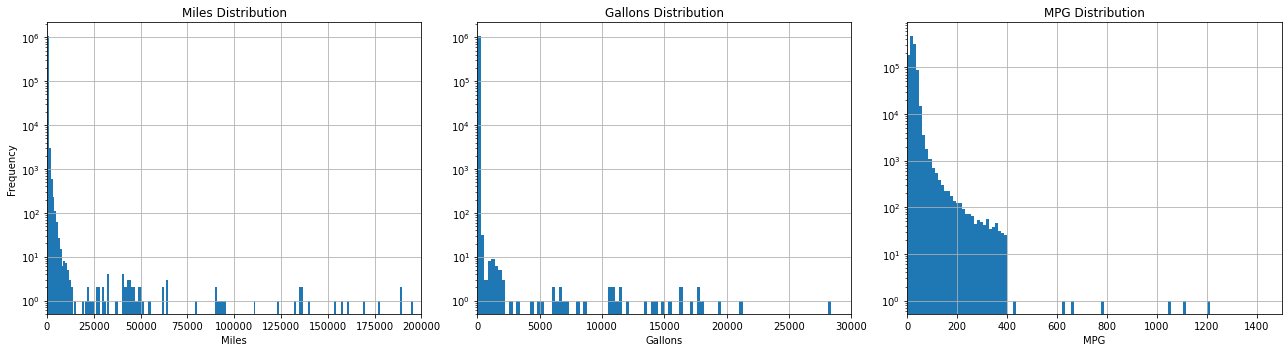

In [164]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Miles Distribution
df["miles_num"].dropna().hist(bins=200, ax=axes[0])
axes[0].set_title("Miles Distribution")
axes[0].set_xlabel("Miles")
axes[0].set_ylabel("Frequency")
axes[0].set_xlim(0, 200000)
axes[0].set_yscale("log") 

# Gallons Distribution
df["gallons_num"].dropna().hist(bins=100, ax=axes[1])
axes[1].set_title("Gallons Distribution")
axes[1].set_xlabel("Gallons")
axes[1].set_xlim(0, 30000)
axes[1].set_yscale("log") 

# MPG Distribution
df["mpg_clean"].dropna().hist(bins=100, ax=axes[2])
axes[2].set_title("MPG Distribution")
axes[2].set_xlabel("MPG")
axes[2].set_xlim(0, 1500)
axes[2].set_yscale("log")

plt.tight_layout()
plt.show()


### 5. Mean, standard deviation, max, min, most frequent and quartiles.

In [165]:
stats = df[["miles_clean", "gallons_clean", "mpg_clean"]].describe(include="all").T

stats["mode"] = df[["miles_clean", "gallons_clean", "mpg_clean"]].mode().iloc[0]

stats

,count,mean,std,min,25%,50%,75%,max,mode
miles_clean,1100129.0,269.453801,725.763437,0.0,181.40,267.0486,342.7641,195321.2,0.000
gallons_clean,1100129.0,12.797430,74.482791,0.0,8.99,11.9540,14.9390,28380.0,10.567
mpg_clean,1100129.0,22.163025,15.744350,0.0,15.60,21.8000,28.5000,1214.3,0.000


## Question 2

### 2.1

In [166]:
# Extract currency from cost_per_gallon
def extract_currency(value):
    if pd.isna(value):
        return None
    v = str(value)

    if "AU$" in v:
        return "AUD"
    elif "NZ$" in v:
        return "NZD"
    elif "CA$" in v:
        return "CAD"
    elif "HK$" in v:
        return "HKD"
    elif "NT$" in v:
        return "TWD"
    elif "US$" in v or "$U" in v or "MXN" in v or "CO$" in v or "CL$" in v or "EC$" in v or "RD$" in v or "J$" in v or "GY$" in v or "BZ$" in v or "Bds$" in v or "TT$" in v or "KY$" in v or "CU$" in v or "BS$" in v:
        return "USD"  
    elif "$" in v:
        return "USD"
    elif "€" in v:
        return "EUR"
    elif "£" in v or "LB£" in v or "SH£" in v or "SY£" in v:
        return "GBP"
    elif "Fr." in v or "Fr" in v or "FCFA" in v or "CFA" in v or "CFPF" in v:
        return "CHF"
    elif "¥" in v or "CN¥" in v:
        return "CNY"
    elif "₩" in v:
        return "KRW"
    elif "₱" in v:
        return "PHP"
    elif "₹" in v or "Rs" in v or "PKRs" in v or "NPRs" in v:
        return "INR"
    elif "R$" in v:
        return "BRL"
    elif "₽" in v or "RUB" in v:
        return "RUB"
    elif "₪" in v:
        return "ILS"
    elif "₦" in v:
        return "NGN"
    elif "₫" in v:
        return "VND"
    elif "฿" in v:
        return "THB"
    elif "₴" in v:
        return "UAH"
    elif "₡" in v:
        return "CRC"
    elif "GH₵" in v:
        return "GHS"
    elif "₮" in v:
        return "MNT"
    elif "₲" in v:
        return "PYG"
    elif "Br" in v:
        return "ETB"
    elif "zł" in v:
        return "PLN"
    elif "Ft" in v:
        return "HUF"
    elif "Kč" in v:
        return "CZK"
    elif "kr" in v or "Skr" in v or "Nkr" in v or "Ikr" in v or "DKr" in v:
        return "SEK"
    elif "AED" in v:
        return "AED"
    elif "MAD" in v:
        return "MAD"
    elif "KZT" in v:
        return "KZT"
    elif "OMR" in v:
        return "OMR"
    elif "QAR" in v or "QR" in v:
        return "QAR"
    elif "TSh" in v:
        return "TZS"
    elif "USh" in v:
        return "UGX"
    elif "ZWL" in v:
        return "ZWL"
    elif "R" in v or "ZAR" in v:
        return "ZAR"
    else:
        return "NONE"

df["currency"] = df["cost_per_gallon"].apply(extract_currency)

print(df[["cost_per_gallon", "currency"]].head(10))

  cost_per_gallon currency
0             NaN     None
1          $5.599      USD
2           £5.45      GBP
3           £5.11      GBP
4          $3.029      USD
5          $3.739      USD
6          $4.639      USD
7          $2.929      USD
8             NaN     None
9          $1.999      USD


### 2.  Create a new column containing the float value of the total spend and the cost per gallon.

In [167]:
# List of currency symbols
currency_symbols = [
    '$', '£', 'RON', '€', 'zł', 'AU$', '₩', 'Ft', 'NZ$', 'Nkr', 'R$', 'CA$', 'RUB', '₪',
    'Rp', 'RM', 'R', 'Skr', 'AR$', 'TL', 'din', 'Ikr', '฿', 'CN¥', 'HK$', 'Dkr', '₡', '₴',
    'IRR', 'S$', 'Rs', 'BGN', '¥', 'AED', 'MKD', '₱', 'BD', 'CL$', 'EC$', '$U', 'LE',
    'MXN', 'CO$', 'CFPF', 'Kč', 'kn', 'JD', 'FCFA', 'NT$', 'BN$', 'RD$', 'S/', 'J$',
    'PKRs', 'Ksh', 'GY$', 'KM', 'Fr', 'CFA', 'MDL', 'MMK', 'N$', '₦', 'ZWL', 'USh',
    'MURs', 'BYN', 'TT$', 'KD', 'B/', 'Bs', 'SLRs', 'SR', 'GTQ', 'QR', 'Br', 'C$', 'BWP',
    'GH₵', 'Tk', 'SR$', 'man', 'KHR', 'BZ$', 'Bds$', 'Kz', 'NPRs', 'OMR', '₲', 'LB£',
    'HNL', 'AMD', 'GEL', '₮', 'MTn', 'ZMW', 'SH£', '₫', 'RWF', 'MGA', 'DT', 'VT', 'MOP$',
    'TMT', 'SY£', 'BS$', 'Af', 'ALL', 'DA', 'TSh', 'KY$', 'NAf', 'KZT', 'YR', 'MAD',
    'CV$', 'IQD', 'CU$', 'KGS', 'L$'
]

# Compile regex pattern for all symbols
pattern = '|'.join(re.escape(symbol) for symbol in currency_symbols)

# Function to convert currency string to float
def parse_currency(value):
    if pd.isna(value):
        return None
    
    # Remove all currency symbols
    value = re.sub(pattern, '', value)
    
    # Replace comma with dot for decimals
    value = value.replace(',', '.')
    try:
        return float(value)
    except ValueError:
        return None

df["total_spent_float"] = df["total_spent"].apply(parse_currency)
df["cost_per_gallon_float"] = df["cost_per_gallon"].apply(parse_currency)

print(df[["total_spent_float", "cost_per_gallon_float"]])

         total_spent_float  cost_per_gallon_float
0                      NaN                    NaN
1                    67.86                  5.599
2                    43.53                  5.450
3                    54.00                  5.110
4                    35.29                  3.029
...                    ...                    ...
1174295              26.08                  1.999
1174296              30.95                  2.449
1174297              34.50                  3.449
1174298              37.13                  3.539
1174299              55.50                  3.199

[1174300 rows x 2 columns]


### 3. Car make, model, year, user ID.

In [168]:
# Split url by "/"
split_url = df["user_url"].str.split('/', expand=True)
split_url

,0,1,2,3,4,5,6,7
0,https:,,www.somewebsite.com,suzuki,swift,2015,674857,None
1,https:,,www.somewebsite.com,bmw,x3,2009,461150,None
2,https:,,www.somewebsite.com,mercedes-benz,e300,1998,133501,None
3,https:,,www.somewebsite.com,bmw,320d,2010,247233,None
4,https:,,www.somewebsite.com,honda,passport,2019,1038865,None
...,...,...,...,...,...,...,...,...
1174295,https:,,www.somewebsite.com,volkswagen,beetle,2005,388391,None
1174296,https:,,www.somewebsite.com,toyota,avalon,2000,432408,None
1174297,https:,,www.somewebsite.com,fiat,500,2013,909694,None
1174298,https:,,www.somewebsite.com,mini,cooper,2019,952426,None


In [169]:
# Split url by "/"
split_url = df["user_url"].str.split('/', expand=True)

# Split split data into 3 parts (as some url postions are different)
full_columns = split_url.iloc[:,-1][split_url.iloc[:,-1].notnull()].index.tolist()
no_vehicle_type = split_url.iloc[:,-2][split_url.iloc[:,-2].notnull() & split_url.iloc[:,-1].isnull()].index.tolist()
no_make = split_url.iloc[:,-3][split_url.iloc[:,-3].notnull() & split_url.iloc[:,-2].isnull()].index.tolist()

In [170]:
split_url.iloc[full_columns]

,0,1,2,3,4,5,6,7
929,https:,,www.somewebsite.com,motorcycle,hyundai,accent,2001,641154
3890,https:,,www.somewebsite.com,motorcycle,honda,cx500,1980,1063180
14744,https:,,www.somewebsite.com,truck,ford,f53,2016,1018696
18880,https:,,www.somewebsite.com,other,mercedes-benz,sprinter_3500,2011,949000
24721,https:,,www.somewebsite.com,truck,ford,f53,2015,817924
...,...,...,...,...,...,...,...,...
1145938,https:,,www.somewebsite.com,truck,ford,f53,2016,581131
1155776,https:,,www.somewebsite.com,truck,ford,f53,2016,744598
1157021,https:,,www.somewebsite.com,truck,ford,f53,2015,381011
1157832,https:,,www.somewebsite.com,motorcycle,honda,cx500,1978,1107312


In [171]:
split_url.iloc[no_vehicle_type] #empty column 7

,0,1,2,3,4,5,6,7
0,https:,,www.somewebsite.com,suzuki,swift,2015,674857,None
1,https:,,www.somewebsite.com,bmw,x3,2009,461150,None
2,https:,,www.somewebsite.com,mercedes-benz,e300,1998,133501,None
3,https:,,www.somewebsite.com,bmw,320d,2010,247233,None
4,https:,,www.somewebsite.com,honda,passport,2019,1038865,None
...,...,...,...,...,...,...,...,...
1174295,https:,,www.somewebsite.com,volkswagen,beetle,2005,388391,None
1174296,https:,,www.somewebsite.com,toyota,avalon,2000,432408,None
1174297,https:,,www.somewebsite.com,fiat,500,2013,909694,None
1174298,https:,,www.somewebsite.com,mini,cooper,2019,952426,None


In [172]:
split_url.iloc[no_make] #empty column 6&7

,0,1,2,3,4,5,6,7
8,https:,,www.somewebsite.com,kianival,2009,789684,None,None
75,https:,,www.somewebsite.com,kiaens,2012,511793,None,None
76,https:,,www.somewebsite.com,fiat,multipla,10363,None,None
467,https:,,www.somewebsite.com,land_rover,defender_90,841556,None,None
545,https:,,www.somewebsite.com,subaru,wrx_sti,680817,None,None
...,...,...,...,...,...,...,...,...
1173653,https:,,www.somewebsite.com,land_rover,defender_90,841556,None,None
1173830,https:,,www.somewebsite.com,honda,accord,480772,None,None
1173874,https:,,www.somewebsite.com,bmw,330d,623895,None,None
1174076,https:,,www.somewebsite.com,lexus,is350,868621,None,None


In [173]:
# create columns
df['car_make'] = None
df['car_model'] = None
df['car_year'] = None
df['user_id'] = None

In [184]:
indices = [full_columns, no_vehicle_type, no_make]

#fill in new columns with relevant values, from relevent indices
for i in range(len(indices)):
    df.loc[indices[i], 'car_make'] = split_url.iloc[indices[i]][4 - round(i/2)]
    df.loc[indices[i], 'user_id'] = split_url.iloc[indices[i]][7 - i]

    if i == 2: #no model or no year
        column_5 = split_url.iloc[indices[i]][4]

        #depending on whether this column contains model or year
        df.loc[no_make, "car_year"] = np.where(pd.to_numeric(column_5, errors="coerce").notna(), column_5, None)
        df.loc[no_make, 'car_model'] = np.where(pd.to_numeric(column_5, errors="coerce").notna(), None, column_5)

    else:    
        df.loc[indices[i], 'car_model'] = split_url.iloc[indices[i]][5 - i]
        df.loc[indices[i], 'car_year'] = split_url.iloc[indices[i]][6 - i]

In [175]:
df[['car_make', 'car_model', 'car_year', 'user_id']]

,car_make,car_model,car_year,user_id
0,suzuki,swift,2015,674857
1,bmw,x3,2009,461150
2,mercedes-benz,e300,1998,133501
3,bmw,320d,2010,247233
4,honda,passport,2019,1038865
...,...,...,...,...
1174295,volkswagen,beetle,2005,388391
1174296,toyota,avalon,2000,432408
1174297,fiat,500,2013,909694
1174298,mini,cooper,2019,952426


## 2.2

### 1. litres filled: use the gallons- consider whether to use UK or US gallons.

In [176]:
# Convert US gallons to litres
df["litres_filled"] = df["gallons_clean"] * 3.78541

print(df[["gallons", "litres_filled"]])

        gallons  litres_filled
0           NaN            NaN
1        12.120      45.879169
2         7.991      30.249211
3        10.575      40.030711
4        11.651      44.103812
...         ...            ...
1174295  13.046      49.384459
1174296  12.637      47.836226
1174297  10.002      37.861671
1174298  10.493      39.720307
1174299  17.350      65.676864

[1174300 rows x 2 columns]


### 2. km driven: use the miles driven to compute this.

In [177]:
# Convert miles to km
df["km_driven"] = df["miles_clean"] * 1.60934

print(df[["miles_clean", "km_driven"]])

         miles_clean   km_driven
0                NaN         NaN
1           382.9920  616.364345
2           227.7435  366.516724
3           494.9100  796.478459
4           244.4000  393.322696
...              ...         ...
1174295     335.2822  539.583056
1174296     252.7400  406.744592
1174297     285.0570  458.753632
1174298     382.9945  616.368369
1174299       0.0000    0.000000

[1174300 rows x 2 columns]


### 3.  litres per 100km: use the two new features to calculate this.

In [178]:
# Compute litres per 100 km
df["litres_per_100km"] = df["litres_filled"] / df["km_driven"] * 100

print(df[["litres_filled", "km_driven", "litres_per_100km"]])

         litres_filled   km_driven  litres_per_100km
0                  NaN         NaN               NaN
1            45.879169  616.364345          7.443514
2            30.249211  366.516724          8.253160
3            40.030711  796.478459          5.025963
4            44.103812  393.322696         11.213137
...                ...         ...               ...
1174295      49.384459  539.583056          9.152337
1174296      47.836226  406.744592         11.760753
1174297      37.861671  458.753632          8.253160
1174298      39.720307  616.368369          6.444248
1174299      65.676864    0.000000               inf

[1174300 rows x 3 columns]


## Question 3: Vehicle Exploration

### 1. Plot the number of unique users per country (remember, we proxy this by currency).

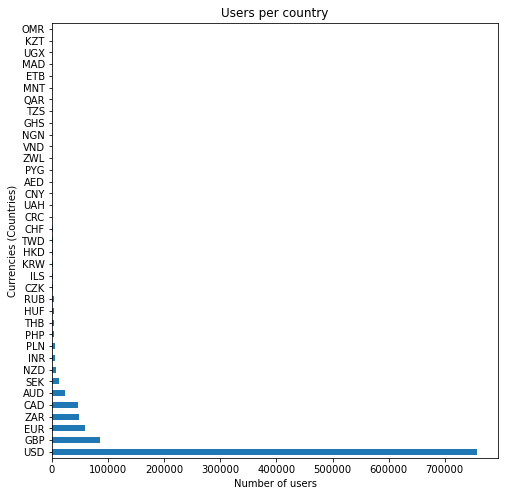

In [179]:
countries = df['currency'].value_counts().drop('NONE')
#plot
plt.figure(figsize=(8, 8))
countries.plot(kind='barh')

plt.xlabel('Number of users')
plt.ylabel('Currencies (Countries)')
plt.title('Users per country')

# display the chart
plt.show()

### 2. Plot the number of unique users per day

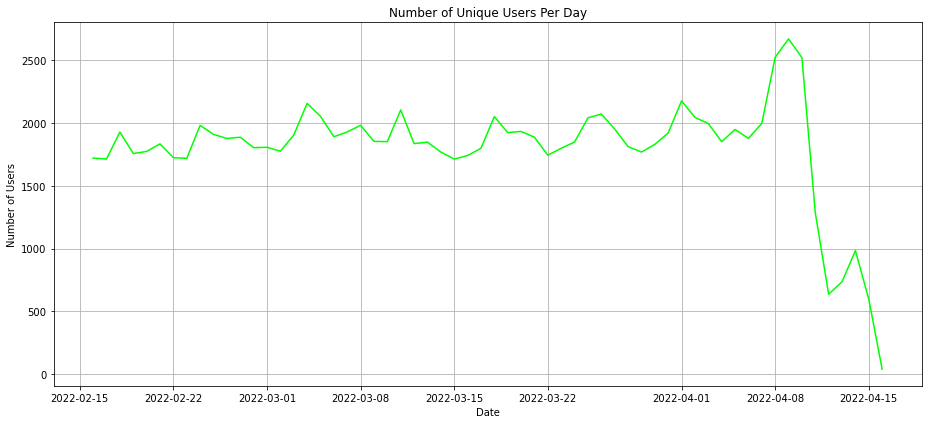

In [180]:
#restrict data to one month back, as dates go back 10+ years!
df['date_captured'] = pd.to_datetime(df['date_captured'], errors='coerce')
df_last_month = df[df['date_captured'] >= df['date_captured'].max() - pd.offsets.DateOffset(months=2)] #filter data to the past 2 months

#plotting line graph
unique_users_per_day = df_last_month.groupby(df_last_month['date_captured'].dt.date)['user_url'].nunique()

plt.figure(figsize=(13, 6))
unique_users_per_day.plot(kind='line', color='lime') 
plt.title('Number of Unique Users Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Users')
plt.grid()
plt.tight_layout()
plt.show()

### 3. Look at the distribution of age of the vehicles per country - look at the year of the vehicle. Remember to look at the date it was refuelled, not the current date.

In [185]:
df_known_currencies = df[df["currency"] != 'NONE'] #exclude none currencies

# new column for age
df_known_currencies['car_age'] = df_known_currencies['date_fueled_clean'].dt.year - pd.to_numeric(df_known_currencies['car_year'])

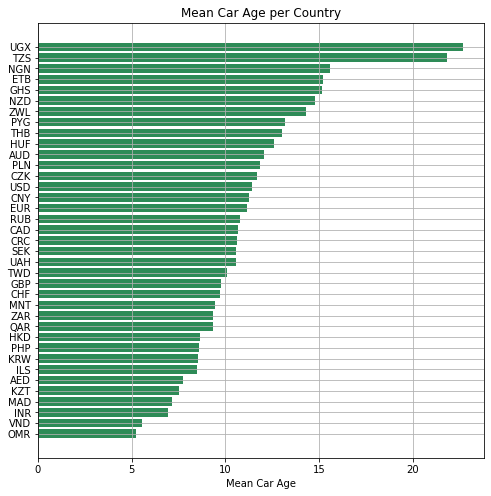

In [186]:
mean_age = df_known_currencies.groupby('currency')['car_age'].mean().sort_values()

# plot horizontal bar plot
plt.figure(figsize=(8, 8))
plt.grid()
plt.barh(mean_age.index, mean_age.values, color='seagreen')
plt.xlabel('Mean Car Age')
plt.title('Mean Car Age per Country')
plt.show()

### 4. Which makes and models of vehicles are the most popular?

In [187]:
#count car models
models = df["car_model"].value_counts().nlargest(5)
models

civic      8082
4runner    7810
corolla    7737
f-150      7661
accord     7633
Name: car_model, dtype: int64

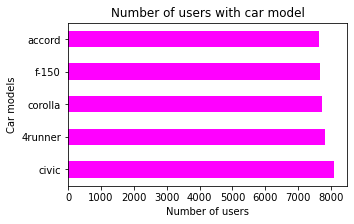

In [188]:
# plot horizontal bar graph
plt.figure(figsize=(5, 3))
models.plot(kind='barh', color='magenta')

# labels 
plt.xlabel('Number of users')
plt.ylabel('Car models')
plt.title('Number of users with car model')

# display the graph
plt.show()

In [189]:
#count car makes
makes = df["car_make"].value_counts().nlargest(5)
makes

civic      8040
4runner    7761
corolla    7706
f-150      7645
accord     7583
Name: car_make, dtype: int64

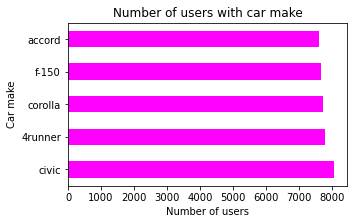

In [190]:
# plot horizontal bar graph
plt.figure(figsize=(5, 3))
makes.plot(kind='barh', color='magenta')

# labels 
plt.xlabel('Number of users')
plt.ylabel('Car make')
plt.title('Number of users with car make')

# display the graph
plt.show()

### The most popular car model is a Civic and make is a Ford

In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174300 entries, 0 to 1174299
Data columns (total 28 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   date_fueled            1125130 non-null  object        
 1   date_captured          1174300 non-null  datetime64[ns]
 2   odometer               1025263 non-null  object        
 3   gallons                1100129 non-null  object        
 4   cost_per_gallon        1093581 non-null  object        
 5   total_spent            1100129 non-null  object        
 6   mpg                    1100129 non-null  object        
 7   miles                  146157 non-null   object        
 8   user_url               1174300 non-null  object        
 9   date_fueled_clean      1174300 non-null  datetime64[ns]
 10  date_fueled_dt         1037090 non-null  datetime64[ns]
 11  gallons_num            1100129 non-null  float64       
 12  miles_num              11001

## Question 4: Outlier Removal
### Q4.1(1) Identify the top 5 currencies by number of transactions

In [192]:
def extract_currency(val):
    if pd.isna(val):
        return None
    val = str(val).strip()
    # Match leading non-numeric characters (currency symbols/abbreviations)
    match = re.match(r"^([^\d.,\s]+)", val)
    return match.group(1) if match else None

# Create a currency column from total_spent
df['currency'] = df['total_spent'].apply(extract_currency)

# Count number of transactions per currency
currency_counts = df['currency'].value_counts().head(5)

print("Top 5 currencies by number of transactions:")
print(currency_counts)

Top 5 currencies by number of transactions:
$      741953
£       87587
€       59273
CA$     46848
R       36424
Name: currency, dtype: int64


### Q4.1 (2): Outlier removal for the top 5 currencies.

The dataset gives gallons (because it’s US-based logging). But fuel is normally compared worldwide in litres (e.g., South Africa, Europe). If we want to look at cost of fuel per unit in different currencies, using gallons is misleading because:
- A US gallon = 3.785 litres
- A UK gallon = 4.546 litres

So if we only compared “cost per gallon” between the US and UK, it wouldn’t be fair — UK gallons are ~20% larger. \\
We will convert everything to litres and then calculating cost per litre, we put all countries on the same standard unit. This way:
- A South African paying R22 per litre can be directly compared to an American paying $1.10 per litre.
- Outlier detection also becomes easier (because a “reasonable” range for cost per litre can be applied across currencies).

In [193]:
def extract_numeric(val):
    if pd.isna(val):
        return None
    val = str(val).strip()
    # Remove any non-numeric leading currency characters
    num = re.sub(r"^[^\d.,-]+", "", val)
    # Remove commas and convert
    try:
        return float(num.replace(",", ""))
    except:
        return None

# Numeric conversions
df['total_spent_num'] = df['total_spent'].apply(extract_numeric)
df['cost_per_gallon_num'] = df['cost_per_gallon'].apply(extract_numeric)

# Convert gallons (also done as gallons_clean)
df['gallons_num'] = pd.to_numeric(df['gallons'].str.replace(",", "", regex=False), errors='coerce')

# Derived features
df['litres'] = df['gallons_num'] * 3.78541  # US gallon to litres
df['cost_per_litre'] = df['total_spent_num'] / df['litres']


The Thresholds are chosen to balance real-world fuel economics and data-entry mistakes in our dataset.
1. Gallons & Litres: A typical passenger car fuel tank is 10–20 gallons (≈ 40–75 litres). Even large trucks rarely exceed 50 gallons in one fill-up. So we set:
   - Gallons: 1 ≤ gallons ≤ 50
   - Litres: 20 ≤ litres ≤ 200
   - entries like 2000 gallons, those are almost certainly typos or users logging incorrectly.

From recent data: https://www.globalpetrolprices.com/gasoline_prices/#hl97 \\
(25-Aug-2025, in USD per litre):
- US (USD): 0.926 $/L
- South Africa (ZAR): 1.201 $/L
- UK (GBP): 1.801 $/L
- Canada (CAD): 1.173 $/L

2. Cost per Litre (currency-specific): This varies across countries and currencies, so we define realistic ranges:
    - USD ($): Historically ranges $0.5–$1.5 per litre, but extreme cases up to $3. We allow 0.2–4 to keep safe margin.
    - GBP (£): UK prices are higher: usually £1–£2 per litre. We allow 0.5–3.
    - EUR (€): Similar to UK, typically €1–€2 per litre. Range: 0.2–3.
    - CAD (CA$): Canada has fuel around CA$1–2 per litre.Range: 0.5–3.
    - ZAR (R): In South Africa, petrol is R20–R30 per litre in recent years. To cover old data (cheaper years) and spikes, we allow 5–40.

If a South African user’s record shows R500 for 10 litres → R50/litre, that’s way too high, so we mark it as an outlier. Similarly, if a US record shows $0.01/litre, it’s unrealistic, maybe a misplaced decimal.

In [ ]:
# Define thresholds by currency
thresholds = {
    '$':    {'cpl_min': 0.2, 'cpl_max': 4},
    '£':    {'cpl_min': 0.5, 'cpl_max': 3},
    '€':    {'cpl_min': 0.5, 'cpl_max': 3},
    'CA$':  {'cpl_min': 0.5, 'cpl_max': 3},
    'R':    {'cpl_min': 5,   'cpl_max': 40},
}

def is_reasonable(row):
    cur = row['currency']
    if cur not in thresholds:
        return True  # keep non-top5
    th = thresholds[cur]
    if pd.isna(row['litres']) or pd.isna(row['cost_per_litre']):
        return False
    if row['gallons_num'] < 1 or row['gallons_num'] > 50:
        return False
    if row['litres'] < 20 or row['litres'] > 200:
        return False
    if row['cost_per_litre'] < th['cpl_min'] or row['cost_per_litre'] > th['cpl_max']:
        return False
    return True

# Apply filter
df['reasonable'] = df.apply(is_reasonable, axis=1)

# Count removals
removed_counts = df.loc[df['currency'].isin(thresholds.keys())].groupby('currency')['reasonable'].apply(lambda x: (~x).sum())
kept_counts = df.loc[df['currency'].isin(thresholds.keys())].groupby('currency')['reasonable'].sum()

removed_counts, kept_counts

### 4.1 (3) How many values have been removed after accounting for outliers?

In [ ]:
# Vectorized filtering instead of apply
top5 = ['$', '£', '€', 'CA$', 'R']
mask = df['currency'].isin(top5)

reasonable = pd.Series(True, index=df.index)

# Gallons and litres constraints
reasonable &= ~mask | ((df['gallons_num'] >= 1) & (df['gallons_num'] <= 50))
reasonable &= ~mask | ((df['litres'] >= 20) & (df['litres'] <= 200))

# Cost per litre constraints (per currency)
for cur, th in thresholds.items():
    cur_mask = df['currency'] == cur
    reasonable[cur_mask] &= df.loc[cur_mask, 'cost_per_litre'].between(th['cpl_min'], th['cpl_max'], inclusive="both")

df['reasonable'] = reasonable

# Counts
removed_counts = df.loc[mask].groupby('currency')['reasonable'].apply(lambda x: (~x).sum())
kept_counts = df.loc[mask].groupby('currency')['reasonable'].sum()
total_counts = removed_counts + kept_counts
removed_pct = (removed_counts / total_counts * 100).round(2)

summary = pd.DataFrame({
    "Total Transactions": total_counts,
    "Removed": removed_counts,
    "Kept": kept_counts,
    "Removed %": removed_pct
})

summary

,Total Transactions,Removed,Kept,Removed %
currency,,,,
$,-741953,-1406437,664484,189.558773
CA$,-46848,-89750,42902,191.577015
R,-36424,-68307,31883,187.532945
£,-87587,-164306,76719,187.591766
€,-59273,-108954,49681,183.817252
